<a href="https://colab.research.google.com/github/meka-williams/Capstone-Finance-AI-Project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The Lost Boy:
#The Hull moving average and the Directional Moving Index (ADX)

In [1]:
#imports

import requests
from google.colab import userdata
import os, json
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
#API setup

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "GPOTJ4638HWF4A6H")
BASE_URL = "https://www.alphavantage.co/query"

In [3]:
#initial data fetch

def _fetch_json(params, retries=3, sleep_s=15):

    for i in range(retries):
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        payload = r.json()

        #return if valid data was retrieved
        if any("Time Series" in k for k in payload.keys()):
            return payload

        #API limit error
        if "Note" in payload and i < retries - 1:
            print("The API limit has been hit, retrying")
            time.sleep(sleep_s)
            continue

        #payload for debugging
        return payload
    return payload


In [4]:
#time series fetch - 5 minute interval used to show volatility


def fetch_intraday(symbol: str, interval: str = "5min", outputsize: str = "compact") -> pd.DataFrame:
    """
    Returns DataFrame indexed by datetime with numeric columns.
    """

    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": interval,
        "outputsize": outputsize,
        "apikey": API_KEY,
    }

    #data fetch
    payload = _fetch_json(params)
    key = next((k for k in payload.keys() if "Time Series" in k), None)
    if not key:
        raise ValueError(f"Unexpected API response for {symbol}: {payload}")

    df = pd.DataFrame(payload[key]).T
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns=lambda c: c.split(". ", 1)[-1])  # "1. open" -> "open"
    df = df.apply(pd.to_numeric, errors="coerce").sort_index()

    #save data to CSV
    out_path = DATA_DIR / f"{symbol}_{interval}_intraday.csv"
    df.to_csv(out_path)
    print(f"Downloaded {symbol} ({interval}): {len(df)} rows → {out_path}")
    print(f"Date range: {df.index.min()} → {df.index.max()}")

    return df


Enter a stock symbol (e.g., IBM, AAPL, MSFT): aapl
Downloaded AAPL (5min): 4032 rows → data/AAPL_5min_intraday.csv
Date range: 2025-09-15 04:00:00 → 2025-10-13 19:55:00

--- Sample of the extracted data ---
                       open    high     low   close  volume
2025-09-15 04:00:00  234.54  235.44  234.12  235.06   29839
2025-09-15 04:05:00  235.21  235.40  235.05  235.25    6390
2025-09-15 04:10:00  235.24  235.36  235.00  235.13    8446
2025-09-15 04:15:00  235.13  235.22  234.99  235.15    3830
2025-09-15 04:20:00  235.15  235.90  235.08  235.86   22175

--- Data summary ---
              open         high          low        close        volume
count  4032.000000  4032.000000  4032.000000  4032.000000  4.032000e+03
mean    250.752226   250.998327   250.239993   250.770367  3.305537e+05
std       7.273556     7.255136     7.736212     7.251794  2.258434e+06
min     228.491200   235.220000   195.270000   235.060000  2.600000e+01
25%     245.757500   246.257500   245.288200   245.

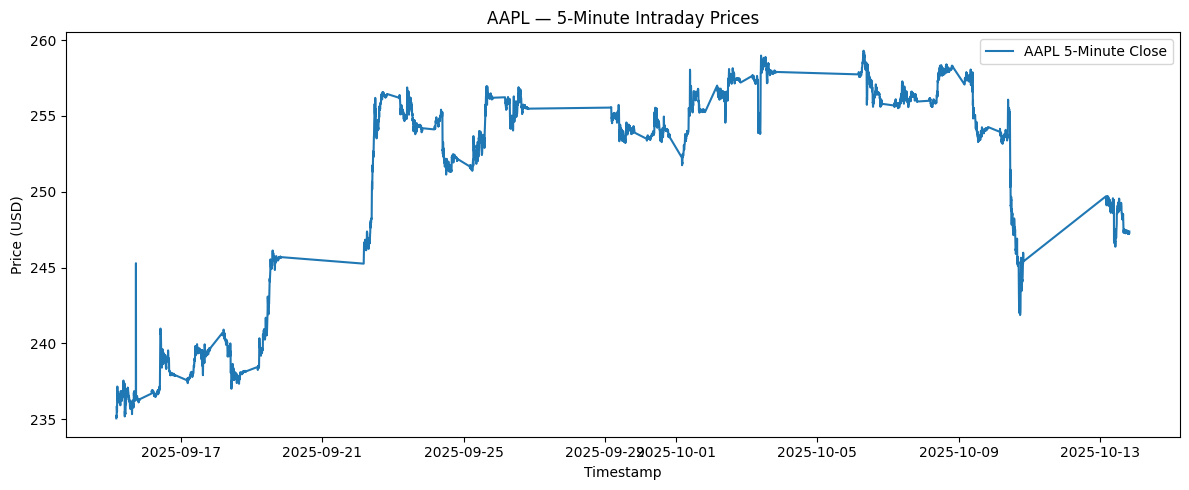

In [5]:
#initial test to validate data extraction

symbol = input("Enter a stock symbol (e.g., IBM, AAPL, MSFT): ").upper()
df = fetch_intraday(symbol, interval="5min", outputsize="full")

#show first 5 rows
print("\n--- Sample of the extracted data ---")
print(df.head())
print("\n--- Data summary ---")
print(df.describe())


#vis
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["close"], label=f"{symbol} 5-Minute Close", color="tab:blue")
plt.title(f"{symbol} — 5-Minute Intraday Prices")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

=== Summary statistics ===
           open      high       low     close        volume
count  4032.000  4032.000  4032.000  4032.000  4.032000e+03
mean    250.752   250.998   250.240   250.770  3.305537e+05
std       7.274     7.255     7.736     7.252  2.258434e+06
min     228.491   235.220   195.270   235.060  2.600000e+01
25%     245.758   246.258   245.288   245.854  2.239250e+03
50%     254.060   254.200   253.856   254.062  1.455250e+04
75%     256.110   256.293   255.910   256.110  3.037980e+05
max     259.310   272.048   259.210   259.300  1.194788e+08


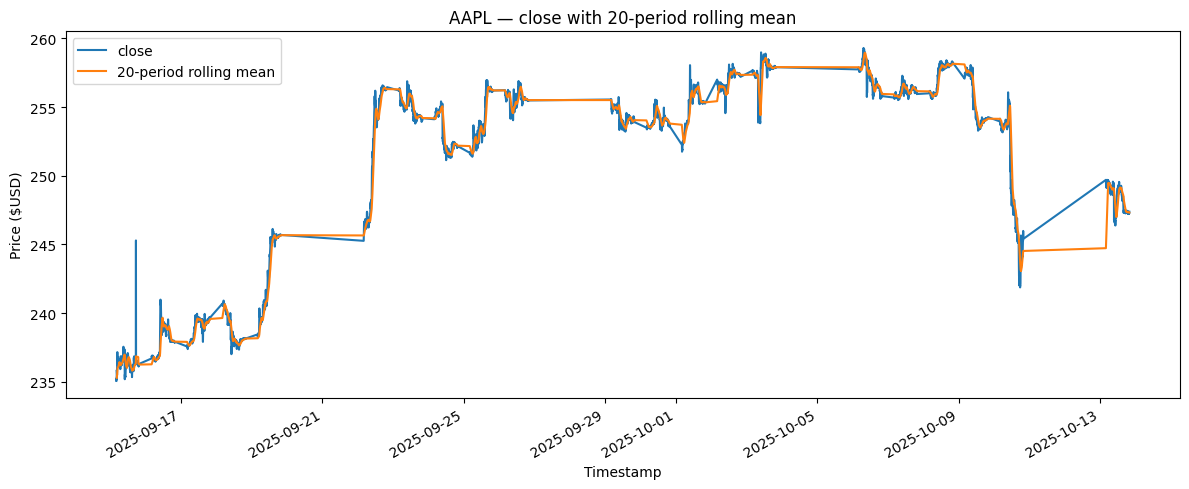

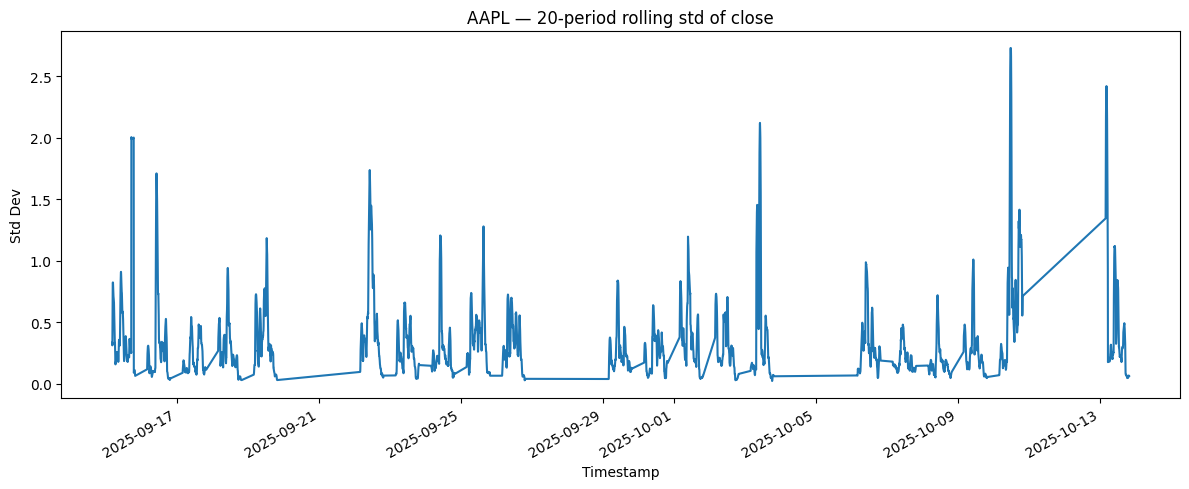

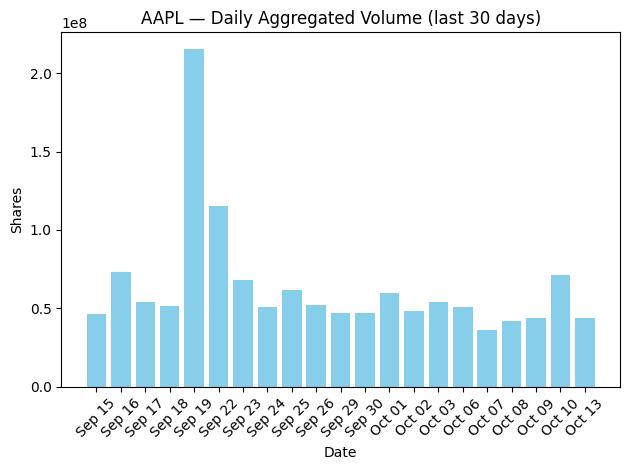

In [6]:
#exploratory visuals (line plot, rolling stats) + summary stats

price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"

#rolling stats
rolling_window = 20
df["roll_mean_20"] = df[price_col].rolling(rolling_window, min_periods=5).mean()
df["roll_std_20"]  = df[price_col].rolling(rolling_window, min_periods=5).std()

#daily returns
df["return_1d"] = df[price_col].pct_change()


#summary stats
summary = df[["open","high","low",price_col,"volume"]].describe().round(3)
print("=== Summary statistics ===")
print(summary)

#save summary csv
DATA_DIR = Path("data")
summary.to_csv(DATA_DIR / f"{symbol}_summary_stats.csv")


#plots

#price with rolling mean
plt.figure(figsize=(12, 5))
df[price_col].plot(label=price_col)
df["roll_mean_20"].plot(label=f"{rolling_window}-period rolling mean")
plt.title(f"{symbol} — {price_col} with {rolling_window}-period rolling mean")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Price ($USD)")
plt.tight_layout()
plt.show()


#rolling volatility proxy (std dev)
plt.figure(figsize=(12, 5))
df["roll_std_20"].plot()
plt.title(f"{symbol} — {rolling_window}-period rolling std of {price_col}")
plt.xlabel("Timestamp")
plt.ylabel("Std Dev")
plt.tight_layout()
plt.show()



#volume by day
df["date"] = df.index.date
daily_volume = df.groupby("date")["volume"].sum()

#last 30 trading days
daily_volume_last = daily_volume[-30:]

positions = range(len(daily_volume_last))
plt.bar(positions, daily_volume_last.values, color="skyblue")
plt.xticks(positions, [d.strftime("%b %d") for d in daily_volume_last.index], rotation=45)
plt.title(f"{symbol} — Daily Aggregated Volume (last 30 days)")
plt.xlabel("Date")
plt.ylabel("Shares")
plt.tight_layout()
plt.show()



In [ ]:
# Identifying Time Series Components

# Decompose the series into trend, seasonality, and residuals.
# Perform ACF and PACF analysis.
# Run stationarity tests (ADF).
# Report with plots and interpretations of time series characteristics.

=== TIME SERIES CHARACTERISTICS REPORT ===



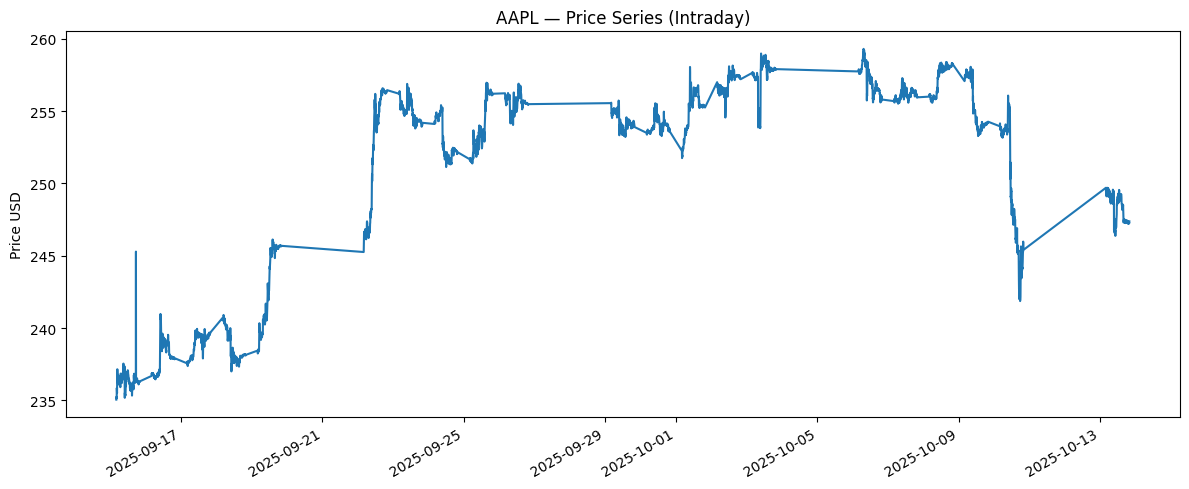

The raw price series shows an upward/downward drift and volatility clustering, suggesting it is likely non-stationary.


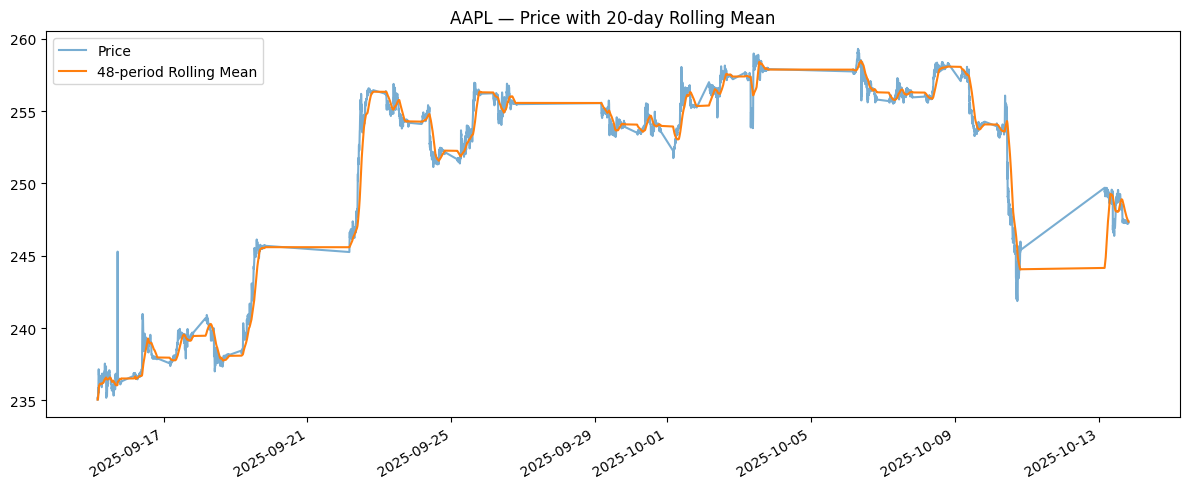

Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.


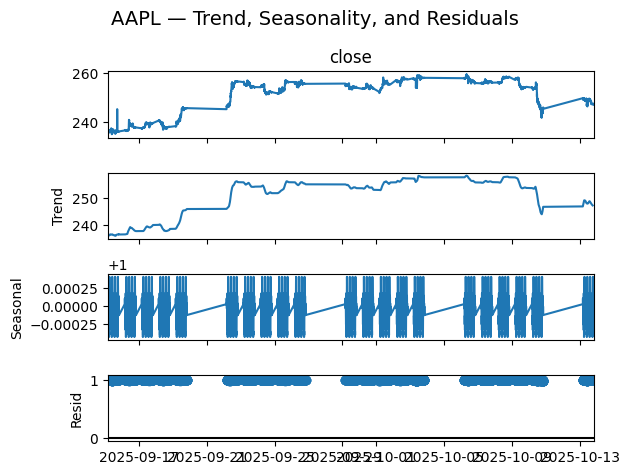

Decomposition separates the series into:
- Trend: Long-term direction of the stock price.
- Seasonality: Repeating short-term cycles (monthly/weekly effects).
- Residuals: Irregular noise not explained by trend or seasonality.



<Figure size 1000x400 with 0 Axes>

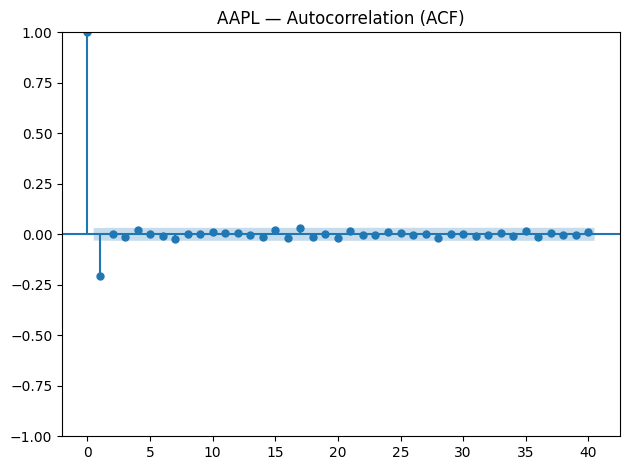

<Figure size 1000x400 with 0 Axes>

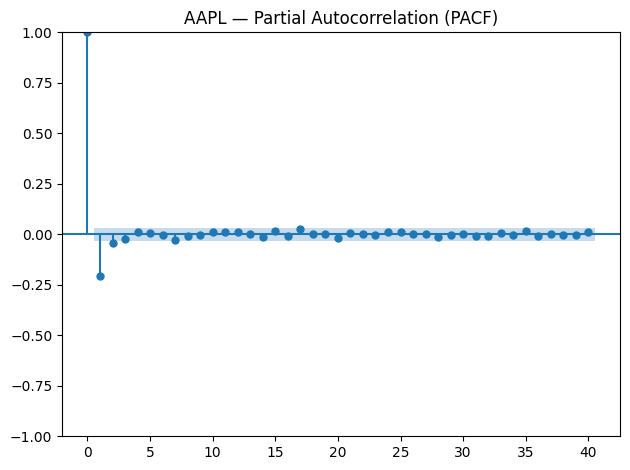

ACF shows correlations with past lags; PACF isolates direct effects of lags. These help identify ARIMA model orders.

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -40.9825
p-value      : 0.0000
Critical Values: {'1%': np.float64(-3.4319744965800596), '5%': np.float64(-2.8622578137065133), '10%': np.float64(-2.567152099644593)}
The series is stationary. The null hypothesis is rejected.


In [7]:
#prep & clean df for analysis

df = df.sort_index()

#dynamic column names
price_col = next((c for c in df.columns if "close" in c.lower()), "close")
returns_col = "return_1d"
if returns_col not in df:
    df[returns_col] = df[price_col].pct_change()

#frequency
inferred_freq = pd.infer_freq(df.index[:10])
period = 30 if inferred_freq and "D" in inferred_freq else 48


print("=== TIME SERIES CHARACTERISTICS REPORT ===\n")
# 1) Plot the raw series
plt.figure(figsize=(12, 5))
df[price_col].plot(color="tab:blue")
plt.title(f"{symbol} — Price Series ({'Daily' if 'D' in str(inferred_freq) else 'Intraday'})")
plt.ylabel("Price USD")
plt.tight_layout()
plt.show()
print("The raw price series shows an upward/downward drift and volatility clustering, "
      "suggesting it is likely non-stationary.")


# 2) Plot rolling stats
df["roll_mean"] = df[price_col].rolling(window=period, min_periods=1).mean()
plt.figure(figsize=(12, 5))
df[price_col].plot(label="Price", alpha=0.6, color="tab:blue")
df["roll_mean"].plot(label=f"{period}-period Rolling Mean", color="tab:orange")
plt.title(f"{symbol} — Price with 20-day Rolling Mean")
plt.legend()
plt.tight_layout()
plt.show()
print("Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.")


# 3) Decomposition (Trend/Seasonality/Residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[price_col].dropna(), model="multiplicative", period=period)
result.plot()
plt.suptitle(f"{symbol} — Trend, Seasonality, and Residuals", fontsize=14)
plt.tight_layout()
plt.show()
print("Decomposition separates the series into:\n"
      "- Trend: Long-term direction of the stock price.\n"
      "- Seasonality: Repeating short-term cycles (monthly/weekly effects).\n"
      "- Residuals: Irregular noise not explained by trend or seasonality.\n")

# 4) ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df['return_1d'].dropna(), lags=40)
plt.title(f"{symbol} — Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df[returns_col].dropna(), lags=40, method="ywm")
plt.title(f"{symbol} — Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()
print("ACF shows correlations with past lags; PACF isolates direct effects of lags. "
      "These help identify ARIMA model orders.")

# 5) ADF Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df[returns_col].dropna(), autolag='AIC')
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("The series is stationary. The null hypothesis is rejected.")
else:
    print("The series is non-stationary. Fail to reject null hypothesis. Differencing needed.")



In [ ]:
# Dealing with Non-Stationarity & Modeling

# Apply differencing, transformations, or detrending as needed.
# Implement and compare MA, AR, and ARIMA models.
# Evaluate model accuracy (e.g., AIC, BIC, RMSE).
# Provide consulting-style recommendations to your client.

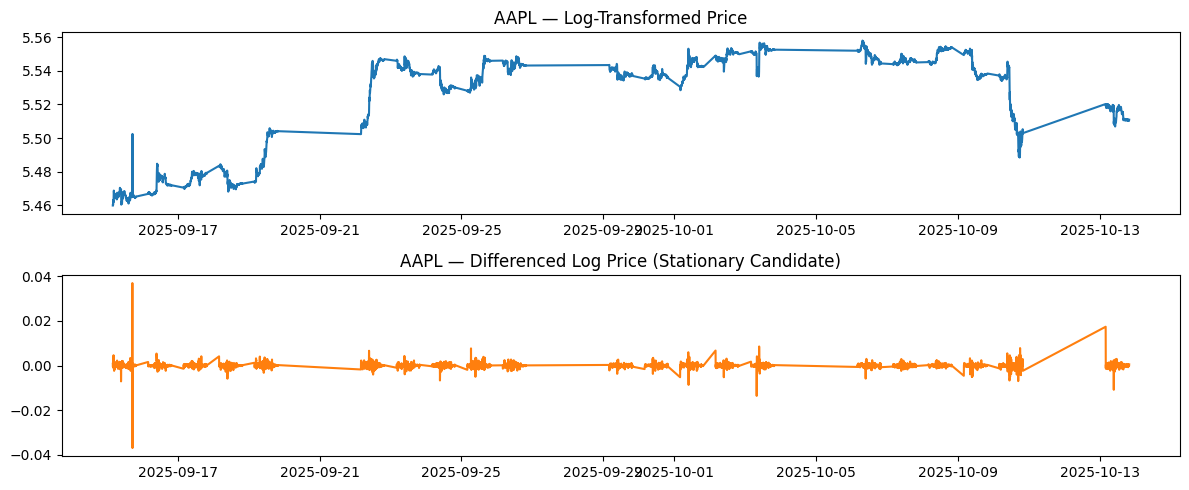

=== ADF on Differenced Log Price ===
ADF Statistic: -40.9876
p-value      : 0.0000
Critical Values: {'1%': np.float64(-3.4319744965800596), '5%': np.float64(-2.8622578137065133), '10%': np.float64(-2.567152099644593)}


In [8]:
# Apply Differencing / Transformations

# Log-transform (helps stabilize variance)
df["log_price"] = np.log(df[price_col])

# First difference of log price (approx daily returns)
df["diff_log_price"] = df["log_price"].diff()

# Drop NaNs
stationary_series = df["diff_log_price"].dropna()

#before vs after differencing
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(df.index, df["log_price"], color="tab:blue")
plt.title(f"{symbol} — Log-Transformed Price")

plt.subplot(2, 1, 2)
plt.plot(stationary_series, color="tab:orange")
plt.title(f"{symbol} — Differenced Log Price (Stationary Candidate)")
plt.tight_layout()
plt.show()


# Re-run ADF test
adf_result = adfuller(stationary_series, autolag="AIC")

print("=== ADF on Differenced Log Price ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])

In [10]:
# AR, MA, ARIMA Models

from statsmodels.tsa.arima.model import ARIMA

results = {}

# AR(1) model
model_ar = ARIMA(stationary_series, order=(1,0,0))
fit_ar = model_ar.fit()
results["AR(1)"] = fit_ar

# MA(1) model
model_ma = ARIMA(stationary_series, order=(0,0,1))
fit_ma = model_ma.fit()
results["MA(1)"] = fit_ma

# ARIMA(1,1,1) model (includes differencing)
model_arima = ARIMA(df[price_col], order=(1,1,1))
fit_arima = model_arima.fit()
results["ARIMA(1,1,1)"] = fit_arima

# Compare summary outputs
for name, model in results.items():
    print(f"\n=== {name} ===")
    print(model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== AR(1) ===
                               SARIMAX Results                                
Dep. Variable:         diff_log_price   No. Observations:                 4031
Model:                 ARIMA(1, 0, 0)   Log Likelihood               21007.251
Date:                Tue, 14 Oct 2025   AIC                         -42008.502
Time:                        02:44:11   BIC                         -41989.597
Sample:                             0   HQIC                        -42001.803
                               - 4031                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.259e-05   1.98e-05      0.637      0.524   -2.61e-05    5.13e-05
ar.L1         -0.2054      0.002   -103.463      0.000      -0.209      -0.201
sigma2      1.742e-06   4.55e-09    3

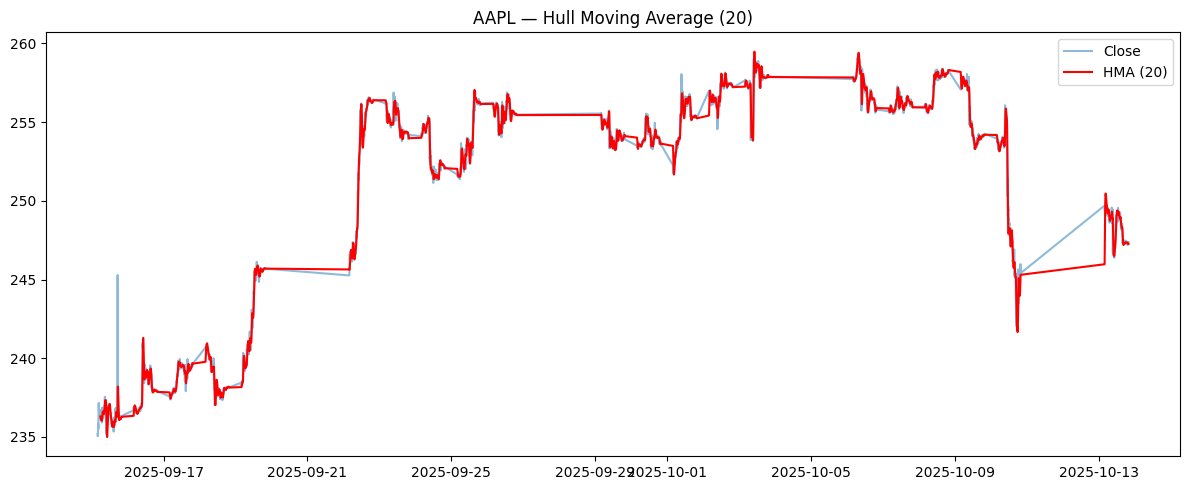

In [11]:
#hull moving average

#weighted moving average - used for hull formula
def WMA(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

#hull moving average
def HMA(series, period=20):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))
    wma_half = WMA(series, half_length)
    wma_full = WMA(series, period)
    diff = 2 * wma_half - wma_full
    return WMA(diff, sqrt_length)

#plot with 20
df["HMA_20"] = HMA(df[price_col], 20)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df[price_col], label="Close", alpha=0.5)
plt.plot(df.index, df["HMA_20"], label="HMA (20)", color="red")
plt.title(f"{symbol} — Hull Moving Average (20)")
plt.legend()
plt.tight_layout()
plt.show()




=== Trend Strength Analysis — ADX / DMI ===


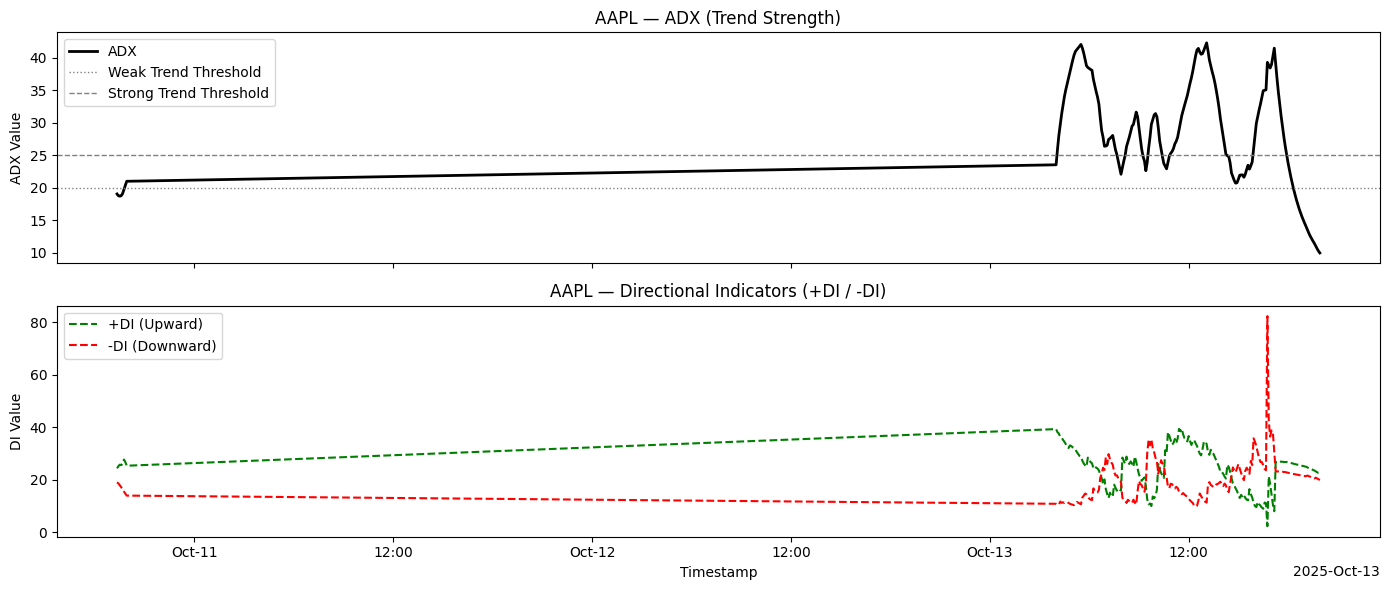

Interpretation:
• ADX > 25 → strong trend; ADX < 20 → weak/sideways trend.
• +DI > -DI → bullish trend; -DI > +DI → bearish trend.
• Crossovers of +DI and -DI indicate potential buy/sell signals.


In [13]:
#directional moving index (DMI) & ADX visualization

from ta.trend import ADXIndicator

print("\n=== Trend Strength Analysis — ADX / DMI ===")

#smaller interval range for graph clarity and readability
window = 14
N = 200

#DMI calculations
adx_indicator = ADXIndicator(
    high=df["high"],
    low=df["low"],
    close=df[price_col],
    window=window
)

df["ADX"] = adx_indicator.adx()
df["DMI_plus"] = adx_indicator.adx_pos()
df["DMI_minus"] = adx_indicator.adx_neg()

#only plot recent data
df_plot = df.iloc[-N:]

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

# 1) ADX — trend strength
axes[0].plot(df_plot.index, df_plot["ADX"], color="black", linewidth=2, label="ADX")
axes[0].axhline(20, color="grey", linestyle=":", linewidth=1, label="Weak Trend Threshold")
axes[0].axhline(25, color="grey", linestyle="--", linewidth=1, label="Strong Trend Threshold")
axes[0].set_title(f"{symbol} — ADX (Trend Strength)")
axes[0].set_ylabel("ADX Value")
axes[0].legend()
axes[0].xaxis.set_major_locator(locator)
axes[0].xaxis.set_major_formatter(formatter)

# 2) DI+ and DI− — trend direction
axes[1].plot(df_plot.index, df_plot["DMI_plus"], color="green", linestyle="--", linewidth=1.5, label="+DI (Upward)")
axes[1].plot(df_plot.index, df_plot["DMI_minus"], color="red", linestyle="--", linewidth=1.5, label="-DI (Downward)")
axes[1].set_title(f"{symbol} — Directional Indicators (+DI / -DI)")
axes[1].set_ylabel("DI Value")
axes[1].legend()
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()

#results
print("Interpretation:")
print("• ADX > 25 → strong trend; ADX < 20 → weak/sideways trend.")
print("• +DI > -DI → bullish trend; -DI > +DI → bearish trend.")
print("• Crossovers of +DI and -DI indicate potential buy/sell signals.")


In [14]:
#evaluating model accuracy

from sklearn.metrics import mean_squared_error

eval_rows = []

for name, model in results.items():
    aic = model.aic
    bic = model.bic

    # fitted values as a Pandas Series
    fitted = pd.Series(model.fittedvalues)

    # target (endogenous) series used by THIS model, with same index as fitted
    # (works across AR/MA on stationary_series and ARIMA on levels)
    try:
        endog = pd.Series(model.model.endog, index=fitted.index)
    except Exception:
        # Fallback: reindex your stationary series to fitted's index
        endog = pd.Series(stationary_series).reindex(fitted.index)

    # align & drop NaNs to ensure equal length
    aligned = pd.concat([endog.rename("y_true"), fitted.rename("y_hat")], axis=1).dropna()

    rmse = np.sqrt(mean_squared_error(aligned["y_true"], aligned["y_hat"]))
    n_used = len(aligned)

    eval_rows.append((name, aic, bic, rmse, n_used))

eval_df = pd.DataFrame(eval_rows, columns=["Model", "AIC", "BIC", "RMSE (in-sample)", "N used"])
print("=== Model Comparison (aligned) ===")
eval_df = eval_df.sort_values("AIC").reset_index(drop=True)
print(eval_df)


=== Model Comparison (aligned) ===
          Model           AIC           BIC  RMSE (in-sample)  N used
0         MA(1) -42017.808431 -41998.903122          0.001318    4031
1         AR(1) -42008.501916 -41989.596606          0.001320    4031
2  ARIMA(1,1,1)   2411.150024   2430.055333        250.875198    4031
